#### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_path =  r'C:\Users\alex.legariamacal\Downloads\fwcajalproject'
print(os.listdir(data_path))

['ab042_cluster_spike_times.csv', 'ab042_cluster_spike_times_2.csv', 'ab042_spikes_dense.npy', 'ab042_trial_data.csv']


In [3]:

# Load trial data
fname = 'ab042_trial_data.csv'
trial_df = pd.read_csv(os.path.join(data_path,fname))
trial_df.head()

trial_type_list = ['ah', 'wh','wm','fa','cr']
for trial_type in trial_type_list:
    print('Trial type, {}, #trials = {}'.format(trial_type, sum(trial_df[trial_type])))

Trial type, ah, #trials = 83
Trial type, wh, #trials = 42
Trial type, wm, #trials = 140
Trial type, fa, #trials = 36
Trial type, cr, #trials = 211


In [4]:
trial_colors = {'ah':'mediumblue',
               'wh':'forestgreen',
               'wm':'crimson',
               'fa':'k',
               'cr':'dimgray'}

#### Load neuron data

In [5]:
fname = 'ab042_cluster_spike_times_2.csv'
neuron_df = pd.read_csv(os.path.join(data_path,fname))
neuron_df.head()

,mouse_name,probe_id,cluster_id,n_spikes,fr,depth,sh,ch,amp,ks_label,group,curated,contam_pct,amplitude,spike_times,area
0,AB042,1,11,18844,3.355170,140,0,12,2.61722,good,good,1,0.0,80.7,[4.58315428e+00 4.82023206e+00 4.99889605e+00 ...,OFC
1,AB042,1,15,82884,14.757500,160,0,15,3.78658,good,good,1,0.0,117.2,[1.19608207e-01 1.19832537e+00 1.26132442e+00 ...,OFC
2,AB042,1,18,22369,3.982790,200,0,18,3.74118,good,good,1,0.2,155.9,[ 16.12826086 16.20829299 16.22845936 ......,OFC
3,AB042,1,25,103197,18.374200,260,0,25,2.54027,good,good,1,0.4,51.9,[9.13752968e-02 1.98307027e-01 3.14838613e-01 ...,OFC
4,AB042,1,27,5487,0.976959,260,0,25,2.98611,good,good,1,9.9,39.2,[3.04006209e+00 3.06686169e+00 3.21399281e+00 ...,OFC


In [6]:
areas = np.unique(neuron_df.area, return_counts=True)
print(areas)
area_list = areas[0]
print(area_list)

(array(['DLS', 'DS', 'OFC', 'Thalamus', 'nS1', 'tjM1', 'wM2', 'wS1'],
      dtype=object), array([135,  30,  72, 139, 121, 166, 126,  58], dtype=int64))
['DLS' 'DS' 'OFC' 'Thalamus' 'nS1' 'tjM1' 'wM2' 'wS1']


#### Load spike time data

In [7]:
fname = 'ab042_spikes_dense.npy'
spike_array = np.load(os.path.join(data_path,fname))
spike_array.shape

(847, 512, 401)

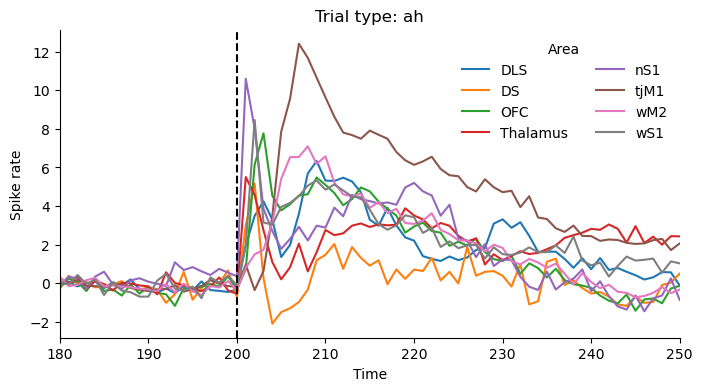

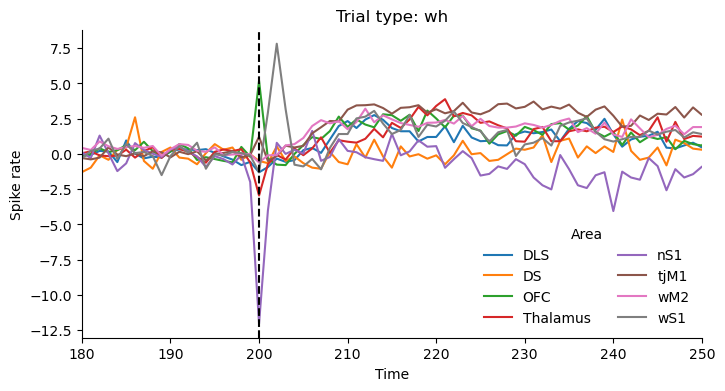

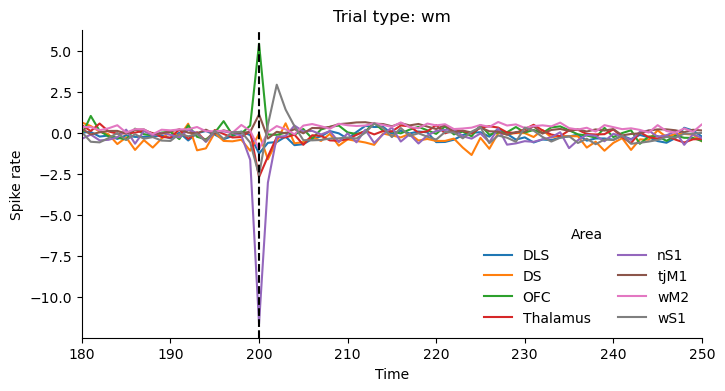

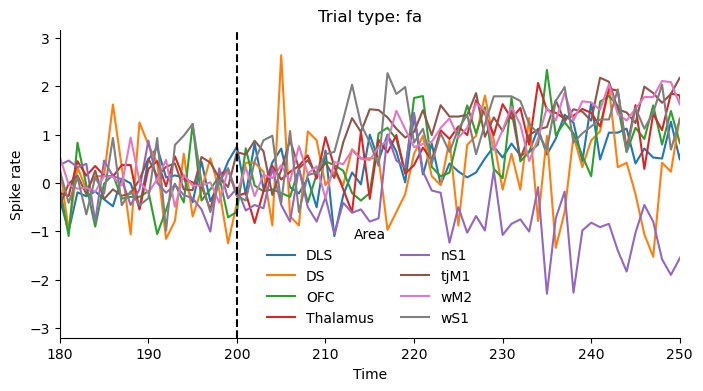

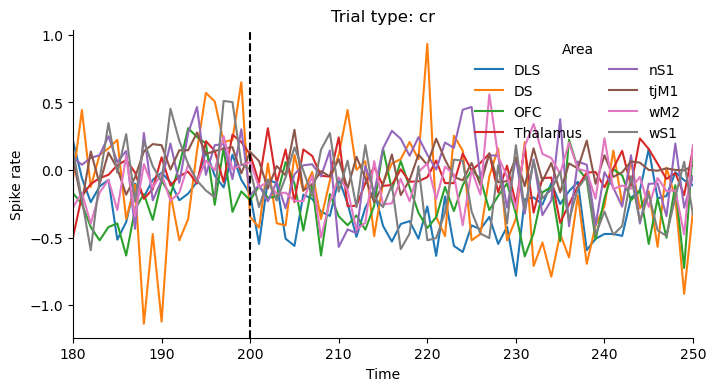

In [8]:
#### PSTHs

all_psths = {}

for trial_type in trial_type_list:
    all_psths[trial_type] = {}
    trial_indices = trial_df[trial_df[trial_type]==1].index.values

    fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100)
    #for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

    for area in area_list:
        neuron_indices = neuron_df[neuron_df.area==area].index.values
        #print('Number of neurons:', len(neuron_indices))

        spike_array_sub = spike_array[neuron_indices][:,trial_indices,:]
        all_psths[trial_type][area] = spike_array_sub
        spike_array_sub_bas = spike_array_sub[:,:,0:100]
        bas = np.mean(spike_array_sub_bas)
        #print('Sub array dim', spike_array_sub.shape)
        
        

        ax.plot((np.mean(spike_array_sub, axis=(0,1)) - bas) /0.01, label=area)


    # Legend
    ax.set_title('Trial type: {}'.format(trial_type))
    ax.axvline(x=200, ls='--',c='k')
    ax.set_xlim(180, 250)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spike rate')
    plt.legend(title='Area', frameon=False, ncol=2)

In [9]:
all_psths['ah'].keys()

dict_keys(['DLS', 'DS', 'OFC', 'Thalamus', 'nS1', 'tjM1', 'wM2', 'wS1'])

In [10]:
all_psths.keys()

dict_keys(['ah', 'wh', 'wm', 'fa', 'cr'])

In [11]:
all_psths["ah"]["DLS"].shape

(135, 83, 401)

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA()

In [15]:
test_ah_tjm1 = all_psths["ah"]["tjM1"].mean(axis=1)
print(test_ah_tjm1.shape)

(166, 401)


Text(0.5, 1.0, 'Average response')

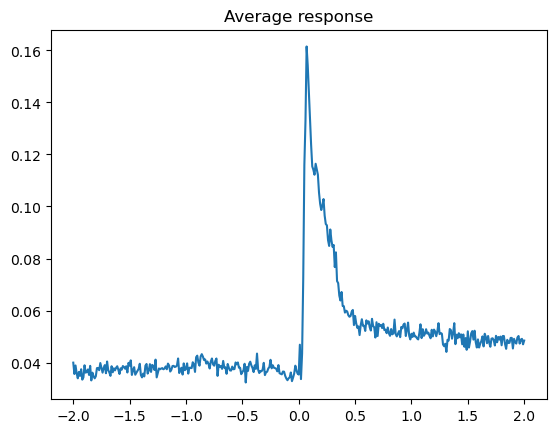

In [16]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-2,2,401), test_ah_tjm1.mean(axis=0))
ax.set_title("Average response")

In [17]:
pca.fit(test_ah_tjm1.T)

PCA()

In [18]:
tjm1_proj = pca.transform(test_ah_tjm1.T)
print(tjm1_proj.shape)

(401, 166)


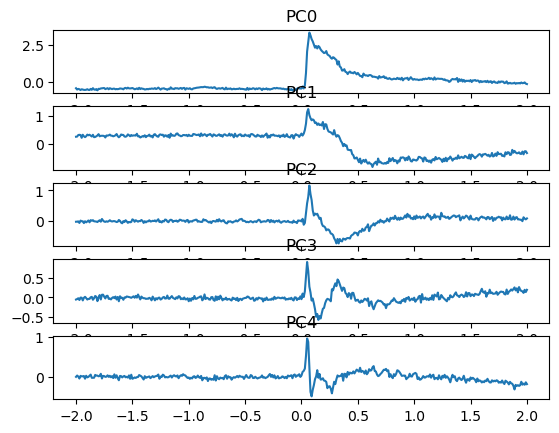

In [22]:
fig, ax = plt.subplots(5,1)
for i in range(5):
    ax[i].plot(np.linspace(-2,2,401), tjm1_proj[:,i])
    ax[i].set_title(f"PC{i}")

Text(0, 0.5, 'variance explained')

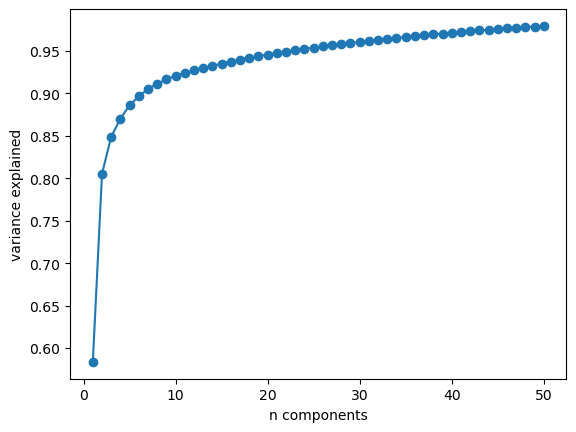

In [24]:
fig, ax = plt.subplots()
ax.plot(np.arange(50)+1,np.cumsum(pca.explained_variance_ratio_)[:50],marker="o")
ax.set_xlim()
ax.set_xlabel("n components")
ax.set_ylabel("variance explained")

In [25]:
all_psths["ah"].keys()

dict_keys(['DLS', 'DS', 'OFC', 'Thalamus', 'nS1', 'tjM1', 'wM2', 'wS1'])

In [28]:
var_expl_ah = {}
for area in all_psths["ah"]:
    c_area = all_psths["ah"][area]
    c_area_mean = c_area.mean(axis=1)
    pca = PCA()
    pca.fit(c_area_mean.T)
    var_expl_ah[area] = pca.explained_variance_ratio_
     

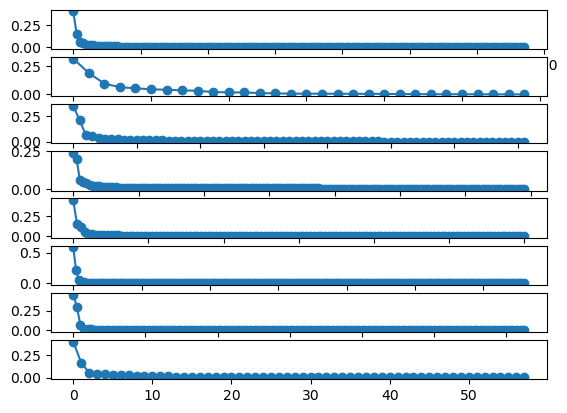

In [31]:
plt.rcParams[source]


fig, ax = plt.subplots(4,2)
counter = 0
for axes in var_expl_ah.keys():
    ax[counter].plot(np.cumsum(var_expl_ah[area]), marker = "o")
    counter += 1

AxesSubplot(0.125,0.712609;0.352273x0.167391)
AxesSubplot(0.547727,0.712609;0.352273x0.167391)
AxesSubplot(0.125,0.511739;0.352273x0.167391)
AxesSubplot(0.547727,0.511739;0.352273x0.167391)
AxesSubplot(0.125,0.31087;0.352273x0.167391)
AxesSubplot(0.547727,0.31087;0.352273x0.167391)
AxesSubplot(0.125,0.11;0.352273x0.167391)
AxesSubplot(0.547727,0.11;0.352273x0.167391)


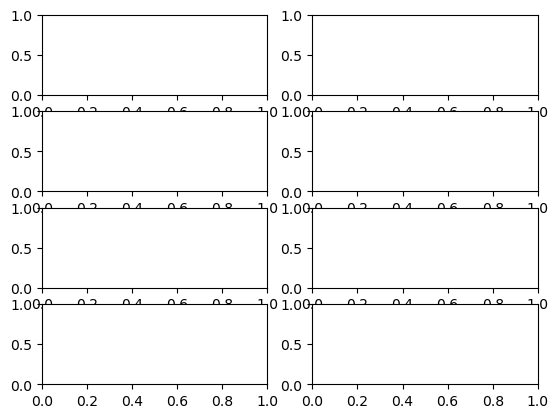

In [32]:

fig, ax = plt.subplots(4,2)
for axes in ax.flat:
    print(axes)